<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Authors: [Yury Kashnitskiy](https://yorko.github.io) (@yorko), Yury Isakov. Edited by Anna Tarelina (@feuerengel), and Kolchenko Sergey (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #2. Spring 2019
## <center>  Competition 1. User Identification with Logistic Regression <br>(beating baselines in the "Alice" competition)

    
Today we are going to practice working with sparse matrices, training Logistic Regression models, and doing feature engineering. We will reproduce a couple of baselines in the  Kaggle Inclass competition ["Catch Me If You Can: Intruder Detection through Webpage Session Tracking"](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) (a.k.a. "Alice"). More credits will be given for beating stronger baselines. 

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) (basics of machine learning are covered here)
 2. Linear classification and regression in 5 parts: 
    - [ordinary least squares](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-1-ols)
    - [linear classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification)
    - [regularization](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-3-regularization)
    - [logistic regression: pros and cons](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit)
    - [validation](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-5-validation)
 3. You can also practice with demo assignments, which are simpler and already shared with solutions: 
    - " Sarcasm detection with logistic regression": [assignment](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit) + [solution](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution)
    - "Linear regression as optimization": [assignment](https://www.kaggle.com/kashnitsky/a4-demo-linear-regression-as-optimization/edit) (solution cannot be officially shared)
    - "Exploring OLS, Lasso and Random Forest in a regression task": [assignment](https://www.kaggle.com/kashnitsky/a6-demo-linear-models-and-rf-for-regression) + [solution](https://www.kaggle.com/kashnitsky/a6-demo-regression-solution)
 4. Alice baseline with logistic regression and "bag of sites", [Kernel](https://www.kaggle.com/kashnitsky/alice-logistic-regression-baseline)
 5. Correct time-aware cross-validation scheme, more features, and hyperparameter optimization, [Kernel](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme)
 6. Other [Kernels](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/kernels?sortBy=voteCount&group=everyone&pageSize=20&competitionId=7173) in this competition. You can share yours as well, but not high-performing ones (Public LB MAE shall be < 0.95). Please don't spoil the competitive spirit. 
 7. If that's still not enough, watch two videos on logistic regression: [mlcourse.ai/video](https://mlcourse.ai/video)

**Your task:**
 1. "Follow me". Complete the missing code and submit your answers via [the google form](https://docs.google.com/forms/d/15PVw9CYlX6QnxRHKIDS161kGAq3v7iiO15W3qKTePEY). Use **the same email** as in A1 (for newcomers: remember your email and use it for all forms during the course). 12 credits max. for this part
 2. "Freeride". Come up with good features to beat the baselines "A2 baseline (10 credits)" and "A2 strong baseline (20 credits)". As names suggest, you'll get 10 more credits for beating the first one, and 10 more (20 in total) for beating the second one. You need to name your [team](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/team) (out of 1 person) in full accordance with the [course rating](https://docs.google.com/spreadsheets/d/1LAy1eK8vIONzIWgcCEaVmhKPSj579zK5lrECf_tQT60/edit?usp=sharing) (for newcomers: you need to name your team with your real full name). You can think of it as a part of the assignment.
 3. If you've beaten "A2 baseline (10 credits)" or performed better, you need to upload your solution as described in [course roadmap](https://mlcourse.ai/roadmap) ("Kaggle Inclass Competition Alice" -> Rules). For all baselines that you see on Public Leaderboard, it's OK to beat them on Public LB as well. But 10 winners will be defined according to the private LB, which will be revealed by @yorko on March 11. 
 
 ### <center> Deadline for A2: 2019 March 10, 20:59 GMT (London time)

# Part 1. Follow me

<img src='../../img/followme_alice.png' width=50%>

*image credit [@muradosmann](https://www.instagram.com/muradosmann/?hl=en)*

In [2]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

##### Problem description

In this competition, we'll analyze the sequence of websites consequently visited by a particular person and try to predict whether this person is Alice or someone else. As a metric we will use [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

### 1. Data Downloading and Transformation
Register on [Kaggle](www.kaggle.com), if you have not done it before.
Go to the competition [page](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) and download the data.

First, read the training and test sets. Then we'll explore the data in hand and do a couple of simple exercises. 

In [3]:
# Read the training and test data sets, change paths if needed
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('data/train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


The training data set contains the following features:

- **site1** – id of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – id of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, 1 for Alice's sessions, and 0 for the other users' sessions
    
User sessions are chosen in the way that they are shorter than 30 min. long and contain no more than 10 websites. I.e. a session is considered over either if a user has visited 10 websites or if a session has lasted over 30 minutes.

There are some empty values in the table, it means that some sessions contain less than ten websites. Replace empty values with 0 and change columns types to integer. Also load the websites dictionary and check how it looks like:

In [4]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


### 2. Brief Exploratory Data Analysis

Before we start training models, we have to perform Exploratory Data Analysis ([EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis)). Today, we are going to perform a shorter version, but we will use other techniques as we move forward. Let's check which websites in the training data set are the most visited. As you can see, they are Google services and a bioinformatics website (a website with 'zero'-index is our missed values, just ignore it):

In [5]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


##### 1. What kind of websites does Alice visit the most?
*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a2_q1__*

- videohostings
- social networks
- torrent trackers
- news

In [6]:
alice_df = train_df[train_df.target == 1]
top_alice_sites = pd.Series(alice_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_alice_sites)
sites_dict.loc[top_alice_sites.index]

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


## Answer: video hostings

Now let us look at the timestamps and try to characterize sessions as timeframes:

In [7]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In order to perform the next task, generate descriptive statistics as you did in the first assignment.

##### 2. Select all correct statements:
*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a2_q2__*

- on average, Alice's session is shorter than that of other users
- more than 1% of all sessions in the dataset belong to Alice
- minimum and maximum durations of Alice's and other users' sessions are approximately the same
- variation about the mean session duration for all users (including Alice) is approximately the same
- less than a quarter of Alice's sessions are greater than or equal to 40 seconds

In [8]:
time_df.describe()

,target,seconds
count,253561.000000,253561.000000
mean,0.009059,138.494370
std,0.094747,295.781742
min,0.000000,0.000000
25%,0.000000,7.000000
50%,0.000000,27.000000
75%,0.000000,113.000000
max,1.000000,1800.000000


In [9]:
x = time_df.groupby([time_df.target]).size()
other_users = x[0]
alice_users = x[1]

In [10]:
other_users

251264

In [11]:
alice_users

2297

## Answer: more than 1% of all sessions in the dataset belong to Alice - FALSE

In [12]:
other_df = time_df[time_df.target==0]
alice_df = time_df[time_df.target==1]

In [13]:
other_df.seconds.mean()

139.28237232552215

In [14]:
alice_df.seconds.mean()

52.29647366129734

## Answer: on average, Alice's session is shorter than that of other users - TRUE

In [15]:
print(alice_df.seconds.min(), alice_df.seconds.max())

0.0 1763.0


In [16]:
print(other_df.seconds.min(), other_df.seconds.max())

0.0 1800.0


## Answer: minimum and maximum durations of Alice's and other users' sessions are approximately the same - TRUE

In [17]:
alice_df.describe()

,target,seconds
count,2297.0,2297.000000
mean,1.0,52.296474
std,0.0,153.309014
min,1.0,0.000000
25%,1.0,4.000000
50%,1.0,11.000000
75%,1.0,38.000000
max,1.0,1763.000000


## Answer: less than a quarter of Alice's sessions are greater than or equal to 40 seconds - TRUE

In [18]:
time_df.describe()

,target,seconds
count,253561.000000,253561.000000
mean,0.009059,138.494370
std,0.094747,295.781742
min,0.000000,0.000000
25%,0.000000,7.000000
50%,0.000000,27.000000
75%,0.000000,113.000000
max,1.000000,1800.000000


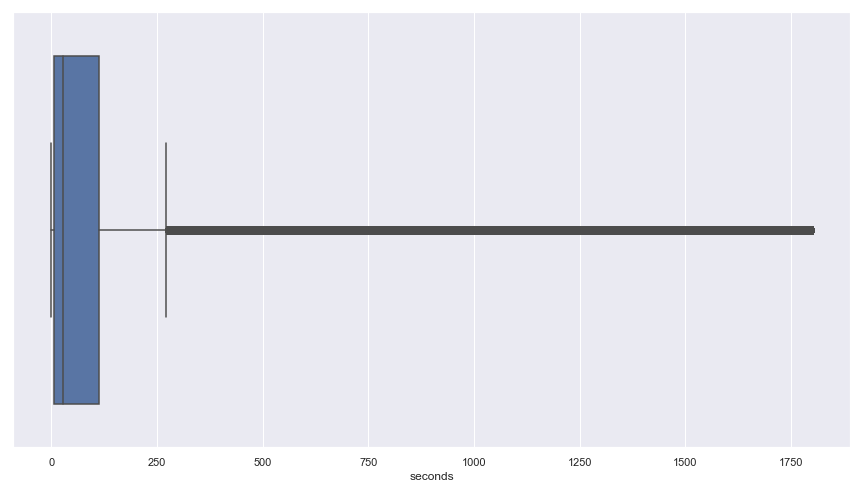

In [19]:
plt.figure(figsize=(15,8))
df = time_df[time_df.seconds < np.percentile(time_df.seconds, 95)]
sns.boxplot(time_df.seconds)

## Answer: variation about the mean session duration for all users (including Alice) is approximately the same - FALSE (Mean is 138 and it is not equally disitributed around this value)

In order to train our first model, we need to prepare the data. First of all, exclude the target variable from the training set. Now both training and test sets have the same number of columns, therefore aggregate them into one dataframe.  Thus, all transformations will be performed simultaneously on both training and test data sets. 

On the one hand, it leads to the fact that both data sets have one feature space (you don't have to worry that you forgot to transform a feature in some data sets). On the other hand, processing time will increase. 
For the enormously large sets it might turn out that it is impossible to transform both data sets simultaneously (and sometimes you have to split your transformations into several stages only for train/test data set).
In our case, with this particular data set, we are going to perform all the transformations for the whole united dataframe at once, and before training the model or making predictions we will just take its appropriate part.

In [20]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

For the very basic model, we will use only the visited websites in the session (but we will not take into account timestamp features). The point behind this data selection is: *Alice has her favorite sites, and the more often you see these sites in the session, the higher probability that this is Alice's session, and vice versa.*

Let us prepare the data, we will take only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values are replaced with zero. Here is how the first rows of the dataframe look like:

In [21]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Sessions are sequences of website indices, and data in this representation is useless for machine learning method (just think, what happens if we switched all ids of all websites). 

According to our hypothesis (Alice has favorite websites), we need to transform this dataframe so each website has a corresponding feature (column) and its value is equal to number of this website visits in the session. It can be done in two lines:

In [22]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [23]:
full_sites_sparse.shape

(336358, 48371)

If you understand what just happened here, then you can skip the next passage (perhaps, you can handle logistic regression too?), If not, then let us figure it out.

### Important detour #1: Sparse Matrices

Let us estimate how much memory it will require to store our data in the example above. Our united dataframe contains 336 thousand samples of 48 thousand integer features in each. It's easy to calculate the required amount of memory, roughly:

$$336K * 48K * 8 bytes = 16M * 8 bytes = 128 GB,$$

(that's the [exact](http://www.wolframalpha.com/input/?i=336358*48371*8+bytes) value). Obviously, ordinary mortals have no such volumes (strictly speaking, Python may allow you to create such a matrix, but it will not be easy to do anything with it). The interesting fact is that most of the elements of our matrix are zeros. If we count non-zero elements, then it will be about 1.8 million, i.е. slightly more than 10% of all matrix elements. Such a matrix, where most elements are zeros, is called sparse, and the ratio between the number of zero elements and the total number of elements is called the sparseness of the matrix.

For the work with such matrices you can use `scipy.sparse` library, check [documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html) to understand what possible types of sparse matrices are, how to work with them and in which cases their usage is most effective. You can learn how they are arranged, for example, in Wikipedia [article](https://en.wikipedia.org/wiki/Sparse_matrix).
Note, that a sparse matrix contains only non-zero elements, and you can get the allocated memory size like this (significant memory savings are obvious):

In [24]:
# How much memory does a sparse matrix occupy?
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# Or just like this:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 7467592 bytes


Let us explore how the matrix with the websites has been formed using a mini example. Suppose we have the following table with user sessions:

| id | site1 | site2 | site3 |
|---|---|---|---|
| 1 | 1 | 0 | 0 |
| 2 | 1 | 3 | 1 |
| 3 | 2 | 3 | 4 |

There are 3 sessions, and no more than 3 websites in each. Users visited four different sites in total (there are numbers from 1 to 4 in the table cells). And let us assume that the mapping is:

 1. vk.com
 2. habrahabr.ru 
 3. yandex.ru
 4. ods.ai

If the user has visited less than 3 websites during the session, the last few values will be zero. We want to convert the original dataframe in a way that each session has a corresponding row which shows the number of visits to each particular site. I.e. we want to transform the previous table into the following form:

| id | vk.com | habrahabr.ru | yandex.ru | ods.ai |
|---|---|---|---|---|
| 1 | 1 | 0 | 0 | 0 |
| 2 | 2 | 0 | 1 | 0 |
| 3 | 0 | 1 | 1 | 1 |


To do this, use the constructor: `csr_matrix ((data, indices, indptr))` and create a frequency table (see examples, code and comments on the links above to see how it works). Here we set all the parameters explicitly for greater clarity:

In [25]:
# data, create the list of ones, length of which equal to the number of elements in the initial dataframe (9)
# By summing the number of ones in the cell, we get the frequency,
# number of visits to a particular site per session
data = [1] * 9

# To do this, you need to correctly distribute the ones in cells
# Indices - website ids, i.e. columns of a new matrix. We will sum ones up grouping them by sessions (ids)
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

# Indices for the division into rows (sessions)
# For example, line 0 is the elements between the indices [0; 3) - the rightmost value is not included
# Line 1 is the elements between the indices [3; 6)
# Line 2 is the elements between the indices [6; 9) 
indptr = [0, 3, 6, 9]

# Aggregate these three variables into a tuple and compose a matrix
# To display this matrix on the screen transform it into the usual "dense" matrix
csr_matrix((data, indices, indptr)).todense()

matrix([[2, 1, 0, 0, 0],
        [0, 2, 0, 1, 0],
        [0, 0, 1, 1, 1]])

As you might have noticed, there are not four columns in the resulting matrix (corresponding to number of different websites) but five. A zero column has been added, which indicates if the session was shorter (in our mini example we took sessions of three). This column is excessive and should be removed from the dataframe (do that yourself).

##### 3. What is the sparseness of the matrix in our small example?
*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a2_q3__*

- 42%
- 47%
- 50%
- 53%

In [26]:
small_csr = csr_matrix((data, indices, indptr)).todense()
df = pd.DataFrame(small_csr)
df = df.drop([0], axis=1)
df

,1,2,3,4
0,1,0,0,0
1,2,0,1,0
2,0,1,1,1


## Answer: 50% sparse

Another benefit of using sparse matrices is that there are special implementations of both matrix operations and machine learning algorithms for them, which sometimes allows to significantly accelerate operations due to the data structure peculiarities. This applies to logistic regression as well. Now everything is ready to build our first model.

### 3. Training the first model

So, we have an algorithm and data for it. Let us build our first model, using [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation from ` Sklearn` with default parameters. We will use the first 90% of the data for training (the training data set is sorted by time), and the remaining 10% for validation. Let's write a simple function that returns the quality of the model and then train our first classifier:

In [27]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [28]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195248606340787
Wall time: 41.2 s


The first model demonstrated the quality  of 0.92 on the validation set. Let's take it as the first baseline and starting point. To make a prediction on the test data set **we need to train the model again on the entire training data set** (until this moment, our model used only part of the data for training), which will increase its generalizing ability:

In [29]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [30]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

If you follow these steps and upload the answer to the competition [page](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2), you will get `ROC AUC = 0.90812` on the public leaderboard ("A2 baseline 1").

### 4. Model Improvement: Feature Engineering

Now we are going to try to improve the quality of our model by adding new features to the data. But first, answer the following question:

##### 4. What years are present in the training and test datasets, if united?
*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a2_q4__*

- 13 and 14
- 2012 and 2013
- 2013 and 2014
- 2014 and 2015

In [31]:
full_df['year'] =  pd.DatetimeIndex(full_df['time1']).year

In [33]:
full_df['year'].value_counts()

2014    261683
2013     74675
Name: year, dtype: int64

## Answer: 2013 and 2014

Create a feature that will be a number in YYYYMM format from the date when the session was held, for example 201407 -- year 2014 and 7th month. Thus, we will take into account the monthly [linear trend](http://people.duke.edu/~rnau/411trend.htm) for the entire period of the data provided.

In [36]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

##### 5. Plot the graph of the number of Alice sessions versus the new feature, start_month. Choose the correct statement:

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a2_q5__*

- Alice wasn't online at all for the entire period
- From the beginning of 2013 to mid-2014, the number of Alice's sessions per month decreased
- The number of Alice's sessions per month is generally constant for the entire period
- From the beginning of 2013 to mid-2014, the number of Alice's sessions per month increased

*Hint: the graph will be more explicit if you treat `start_month` as a categorical ordinal variable*.

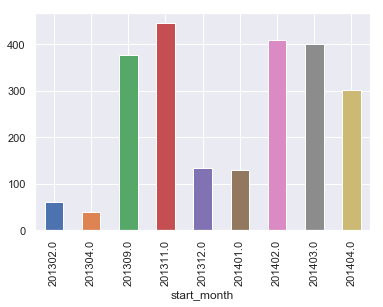

In [35]:
train_df['start_month'] =  train_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')
alice_df = train_df[train_df.target == 1]
alice_df.groupby(alice_df['start_month']).size().plot(kind='bar')

## Answer:

- Alice wasn't online at all for the entire period: TRUE
- From the beginning of 2013 to mid-2014, the number of Alice's sessions per month decreased: FALSE
- The number of Alice's sessions per month is generally constant for the entire period: FALSE
- From the beginning of 2013 to mid-2014, the number of Alice's sessions per month increased: FALSE

In this way, we have an illustration and thoughts about the usefulness of the new feature, add it to the training sample and check the quality of the new model:

In [36]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


The quality of the model has decreased significantly. We added a feature that definitely seemed useful to us, but its usage only worsened the model. Why did it happen?

### Important detour #2: is it necessary to scale features?

Here we give an intuitive reasoning (a rigorous mathematical justification for one or another aspect in linear models you can easily find on the internet). Consider the features more closely: those of them that correspond to the number of visits to a particular web-site per session vary from 0 to 10. The feature `start_month` has a completely different range: from 201301 to 201412, this means the contribution of this variable is significantly greater than the others. It would seem that problem can be avoided if we put less weight in a linear combination of attributes in this case, but in our case logistic regression with regularization is used (by default, this parameter is `C = 1`), which penalizes the model the stronger the greater its weights are. Therefore, for linear methods with regularization, it is recommended to convert features to the same scale (you can read more about the regularization, for example, [here](https://habrahabr.ru/company/ods/blog/322076/)).

One way to do this is standardization: for each observation you need to subtract the average value of the feature and divide this difference by the standard deviation:

$$ x^{*}_{i} = \dfrac{x_{i} - \mu_x}{\sigma_x}$$

The following practical tips can be given:
- It is recommended to scale features if they have essentially different ranges or different units of measurement (for example, the country's population is indicated in units, and the country's GNP in trillions)
- Scale features if you do not have a reason/expert opinion to give a greater weight to any of them
- Scaling can be excessive if the ranges of some of your features differ from each other, but they are in the same system of units (for example, the proportion of middle-aged people and people over 80 among the entire population)
- If you want to get an interpreted model, then build a model without regularization and scaling (most likely, its quality will be worse)
- Binary features (which take only values of 0 or 1) are usually left without conversion, (but)
- If the quality of the model is crucial, try different options and select one where the quality is better

Getting back to `start_month`, let us rescale the new feature and train the model again. This time the quality has increased:

In [37]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196993699549295


##### 6. Add to the training set a new feature "n_unique_sites" – the number of the unique web-sites in a session. Calculate how the quality on the validation set has changed

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a2_q6__*

- It has decreased. It is better not to add a new feature.
- It has not changed.
- It has decreased. The new feature should be scaled.
- I am confused, and I do not know if it's necessary to scale a new feature.

*Tips: use the nunique() function from `pandas`. Do not forget to include the start_month in the set. Will you scale a new feature? Why?*

In [38]:
train_df['n_unique_sites'] = train_df[sites].nunique(axis=1)

In [39]:
# Add the new feature to the sparse matrix
tmp = train_df[['n_unique_sites']].values
tmp2 = full_new_feat[['start_month']].values

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], \
                             tmp2[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.43709203162664434


In [40]:
#scale the new features added and re-compute
tmp = StandardScaler().fit_transform(train_df[['n_unique_sites']])
tmp2 = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], \
                             tmp2[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9156774282760654


## Answer: It has decreased. The new feature should be scaled.

So, the new feature has slightly decreased the quality, so we will not use it. Nevertheless, do not rush to throw features out because they haven't performed well. They can be useful in a combination with other features (for example, when a new feature is a ratio or a product of two others).

#####  7. Add two new features: start_hour and morning. Calculate the metric. Which of these features gives an improvement?

The `start_hour` feature is the hour at which the session started (from 0 to 23), and the binary feature `morning` is equal to 1 if the session started in the morning and 0 if the session started later (we assume that morning means `start_hour` is equal to 11 or less).

Will you scale the new features? Make your assumptions and test them in practice.

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a2_q7__*

- None of the features gave an improvement :(
- `start_hour` feature gave an improvement, and `morning` did not
- `morning` feature gave an improvement, and `start_hour` did not
- Both features gave an improvement

*Tip: find suitable functions for working with time series data in [documentation](http://pandas.pydata.org/pandas-docs/stable/api.html). Do not forget to include the `start_month` feature.*

In [41]:
train_df['start_hour'] =  pd.DatetimeIndex(train_df['time1']).hour
train_df['morning'] = np.where(train_df['start_hour']<=11, 1, 0)

# we know that start_month has to be scaled for the results to be good, so using it scaled
tmp = train_df[['start_hour']].values
tmp2 = train_df[['morning']].values
tmp3 = StandardScaler().fit_transform(full_new_feat[['start_month']])
#with start_hour
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], \
                             tmp3[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

0.9572698982894464


In [42]:
#with morning
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp2[:idx_split,:], \
                             tmp3[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

0.9486638413064166


In [43]:
#with start_hour and morning
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], \
                             tmp2[:idx_split,:], tmp3[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train)) 

0.9585130507610781


In [44]:
# all 3 features scaled
tmp = StandardScaler().fit_transform(train_df[['start_hour']])
tmp2 = StandardScaler().fit_transform(train_df[['morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], \
                             tmp2[:idx_split,:], tmp3[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))


0.9591497984387153


## Answer: Both features gave an improvement

### 5. Regularization and Parameter Tuning

We have introduced features that improve the quality of our model in comparison with the first baseline. Can we do even better? After we have changed the training and test sets, it almost always makes sense to search for the optimal hyperparameters - the parameters of the model that do not change during training.

For example, in week 3, you learned that, in decision trees, the depth of the tree is a hyperparameter, but the feature by which splitting occurs and its threshold is not. 

In the logistic regression that we use, the weights of each feature are changing, and we find their optimal values during training; meanwhile, the regularization parameter remains constant. This is the hyperparameter that we are going to optimize now.

Calculate the quality on a validation set with a regularization parameter, which is equal to 1 by default:

In [40]:
# Find sessions' starting and ending
full_new_feat['min'] = full_df[times].min(axis=1)
full_new_feat['max'] = full_df[times].max(axis=1)

# Calculate sessions' duration in seconds
full_new_feat['duration'] = (full_new_feat['max'] - full_new_feat['min']) / np.timedelta64(1, 's')
full_new_feat = full_new_feat.drop(columns=['min','max'])

In [43]:
# Compose the training set
#full_new_feat['start_hour'] =  pd.DatetimeIndex(full_df['time1']).hour
hour = full_df['time1'].apply(lambda ts: ts.hour)
full_new_feat['start_hour'] = hour
full_new_feat['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
full_new_feat['afternoon'] = ((hour >= 12) & (hour <= 18)).astype('int')
full_new_feat['evening'] = ((hour >= 19) & (hour <= 23)).astype('int')
full_new_feat['night'] = ((hour >= 0) & (hour <= 6)).astype('int')
full_new_feat['n_unique_sites'] = full_df[sites].nunique(axis=1)

tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'n_unique_sites','duration',
                                                           'morning','afternoon','evening','night']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.9645894019100618


## 0.9591528176311175 - earlier score before adding afternoon, evening, night features.

We will try to beat this result by optimizing the regularization parameter. We will take a list of possible values of C and calculate the quality metric on the validation set for each of C-values:

In [44]:
from tqdm import tqdm

# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00, 12.05s/it]


Plot the graph of the quality metric (AUC-ROC) versus the value of the regularization parameter. The value of quality metric corresponding to the default value of C=1 is represented by a horizontal dotted line:

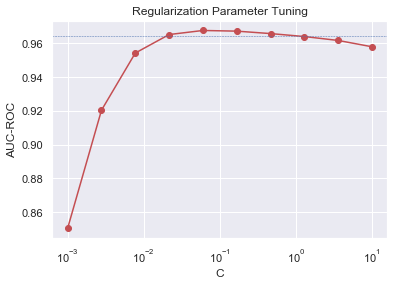

In [47]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 
plt.show()

##### 8. What is the value of parameter C (if rounded to 2 decimals) that corresponds to the highest model quality?

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a2_q8__*

- 0.17
- 0.46
- 1.29
- 3.14

In [45]:
print(max(scores))
print(scores.index(max(scores)))

0.9678397134907178
4


In [46]:
print(Cs[scores.index(max(scores))])
C_max = Cs[scores.index(max(scores))] #old features value, leaving it behind for the answer to be intact.

0.05994842503189409


## Answer: 0.17

For the last task in this assignment: train the model using the optimal regularization parameter you found (do not round up to two digits like in the last question). If you do everything correctly and submit your solution, you should see `ROC AUC = 0.92784` on the public leaderboard ("A2 baseline 2"):

In [47]:
# Train the model on the whole training data set using optimal regularization parameter
C_max = Cs[scores.index(max(scores))]
print(scores, C_max)

C = C_max
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_3.csv') #with added features

[0.8497580419208827, 0.9204548473737857, 0.9545972336951534, 0.9654820261437909, 0.9678397134907178, 0.9673673608393838, 0.9658461407475037, 0.9641069349641804, 0.9617558898405383, 0.9580671915230738] 0.05994842503189409


In [48]:
X_train.shape, X_test.shape

((253561, 48379), (82797, 48379))

In [49]:
full_sites_sparse.shape

(336358, 48371)

The above code has given a ROC AUC score of 0.92784 on the leaderboard. Now on to improvements!

In this part of the assignment, you have learned how to use sparse matrices, train logistic regression models, create new features and selected the best ones, learned why you need to scale features, and how to select hyperparameters. That's a lot!

## Baseline 3 gave score of 0.92329 on leaderboard

Now 0.92344 on the leaderboard.

# Part 2. Freeride

<img src='../../img/snowboard.jpg' width=70%>

*Yorko in Sheregesh, the best place in Russia for snowboarding and skiing.*

In this part, you'll need to beat the 2 more baselines mentioned in the beginning of this assignment. No more step-by-step instructions. But it'll be very helpful for you to study the Kernel "[Correct time-aware cross-validation scheme](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme)".

Here are a few tips for finding new features: think about what you can come up with using existing features, try multiplying or dividing two of them, justify or decline your hypotheses with plots, extract useful information from time series data (time1 ... time10), do not hesitate to convert an existing feature (for example, take a logarithm), etc. Checkout other [Kernels](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/kernels). We encourage you to try new ideas and models - it's fun!

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a2_alice__*

When you get into Kaggle and Xgboost, you'll feel like that, and it's OK :)

<img src='../../img/xgboost_meme.jpg' width=50%>

*More nerdy jokes in the thread ["Nerd Laughing Loud"](https://www.kaggle.com/general/76963)*

# Relax? Not yet

That's it for this part of assignment 2. More credits will be given to the top 10 performers in this competition (from among current participants), check [course roadmap](https://mlcourse.ai/roadmap). Do not spoil the assignment and the competition - don't share high-performing kernels (with LB ROC AUC >= 0.95).

In [80]:
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

In [107]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
X_train.shape, X_test.shape

((253561, 50000), (82797, 50000))

In [61]:
full_new_feat.describe()

,start_month,seconds,duration,start_hour,morning,afternoon,evening,night,n_unique_sites
count,336358.000000,336358.000000,336358.000000,336358.000000,336358.000000,336358.000000,336358.000000,336358.0,336358.000000
mean,201383.176672,137.400404,137.400404,12.341550,0.474025,0.497705,0.028270,0.0,5.641007
std,39.525634,293.208117,293.208117,3.141991,0.499326,0.499995,0.165745,0.0,2.458695
min,201301.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,201401.000000,7.000000,7.000000,10.000000,0.000000,0.000000,0.000000,0.0,4.000000
50%,201403.000000,28.000000,28.000000,12.000000,0.000000,0.000000,0.000000,0.0,6.000000
75%,201404.000000,112.000000,112.000000,15.000000,1.000000,1.000000,0.000000,0.0,8.000000
max,201412.000000,1800.000000,1800.000000,23.000000,1.000000,1.000000,1.000000,0.0,10.000000


In [78]:
max(full_df['site1'])

48370

In [108]:
X_train.shape, full_new_feat.shape

((253561, 50000), (336358, 9))

In [109]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'n_unique_sites','duration',
                                                           'morning','afternoon','evening','night']])
X_train_new = hstack([X_train, tmp_scaled[:idx_split,:]])
X_test_new = hstack([X_test, tmp_scaled[idx_split:,:]])

#X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
#                             tmp_scaled[:idx_split,:]]))
#X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
#                            tmp_scaled[idx_split:,:]]))

In [110]:
X_train_new.shape

(253561, 50008)

In [111]:
# Train the model on the whole training data set using optimal regularization parameter
C = C_max
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train_new, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test_new)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'sub2.csv')

In [112]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

logit = LogisticRegression(random_state=17, class_weight='balanced')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.logspace(-3, 3, 17)

In [113]:
## did not give great results, so marking down

from sklearn.model_selection import cross_val_score

logit_cv = GridSearchCV(estimator=logit, param_grid={'C': c_values}, scoring='roc_auc', cv=skf, verbose=1)

In [114]:
logit_cv.fit(X_train_new, y_train)
logit_cv.score
logit_cv.best_estimator_, logit_cv.best_params_, logit_cv.best_score_

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed: 61.5min finished


(LogisticRegression(C=0.07498942093324558, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 {'C': 0.07498942093324558},
 0.9769444344416663)

In [115]:
# Make a prediction for the test set
y_test = logit_cv.predict_proba(X_test_new)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'lr_cv.csv')

## Score was 0.87986 on the leaderboard.

## Best score of 0.93176!! C = 0.07498942093324558

In [51]:
from sklearn.model_selection import train_test_split

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.2, random_state=17)

In [57]:
from lightgbm import LGBMClassifier
lgbm5 = LGBMClassifier(random_state=17, n_estimators=1000, colsample_bytree=0.66,
                       max_depth=-1, num_leaves=5, reg_alpha=1.2, subsample=0.75,
                       reg_lambda=1, learning_rate=0.5)
lgbm5.fit(X_train_part, y_train_part)
lgbm_valid_pred = lgbm5.predict_proba(X_valid)[:, 1]

print(roc_auc_score(y_valid, lgbm_valid_pred))

0.9840987336554166


In [58]:
lgbm5.fit(X_train, y_train)
y_test = lgbm5.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'lgbm.csv')

## Score was 0.78186

In [59]:
parameters = {'num_leaves': [7, 15, 31, 63, 127, 255],
              'max_depth': [3, 4, 5, 6]}
grid_search = GridSearchCV(estimator=lgbm5, param_grid=parameters, 
                           verbose=1, scoring='roc_auc',
                           n_jobs=4, cv=5)
grid_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 29.6min finished


In [ ]:
grid_search.best_params_, grid_search.best_score_

In [61]:
grid_search.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.5, max_depth=4,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=17, reg_alpha=1.2, reg_lambda=1, silent=True,
        subsample=0.75, subsample_for_bin=200000, subsample_freq=0)

In [62]:
lgbm6 = LGBMClassifier(random_state=17, n_estimators=1000, colsample_bytree=0.66,
                       max_depth=6, num_leaves=15, reg_alpha=1.2, subsample=0.75,
                       reg_lambda=1, learning_rate=0.5)
lgbm6.fit(X_train_part, y_train_part)
lgbm_valid_pred = lgbm6.predict_proba(X_valid)[:, 1]

print(roc_auc_score(y_valid, lgbm_valid_pred))

0.9917426483894418


In [63]:
lgbm6.fit(X_train, y_train)
y_test = lgbm6.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'lgbm6.csv')

## Score = 0.70012

In [52]:
from xgboost import XGBClassifier
xgb = XGBClassifier(seed=17)
xgb.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.9723121105398791

In [65]:
xgb.fit(X_train, y_train)
y_test = xgb.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'xgb.csv')

## Score = 0.87814, let us fine tune parameters

In [53]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=17, silent=True,
       subsample=1)

In [54]:
xgb = XGBClassifier(seed=17, n_estimators=500)
xgb.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.9852545239903169

In [55]:
xgb.fit(X_train, y_train)
y_test = xgb.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'xgb2.csv')

## Score = 0.90371

In [ ]:
parameters = {'num_leaves': [7, 15, 31, 63, 127, 255],
              'max_depth': [3, 4, 5, 6]}
grid_search2 = GridSearchCV(estimator=xgb, param_grid=parameters, 
                           verbose=1, scoring='roc_auc',
                           n_jobs=4, cv=5)
grid_search2 = grid_search2.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 33.4min


In [ ]:
grid_search2.best_params_, grid_search2.best_score_

In [ ]:
grid_search2.best_estimator_

In [ ]:
xgb3 = XGBClassifier(seed=17, n_estimators=500, max_depth=6, num_leaves=15)
xgb3.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb3.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

In [ ]:
xgb3.fit(X_train, y_train)
y_test = xgb3.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'xgb3.csv')

## Score = 0.90039

In [56]:
p1 = pd.read_csv('xgb2.csv')
p2 = pd.read_csv('baseline_3.csv')

In [57]:
p1.columns

Index(['session_id', 'target'], dtype='object')

In [ ]:
p3 = 0.4*p1['target'] + 0.6*p2['target']

In [ ]:
p3.head()

In [ ]:
p3.index += 1

In [ ]:
pd.Series(p3, name='target').to_csv('p3.csv', index_label='session_id', header=True)

## Score = 0.92685

In [58]:
p4 = 0.2*p1['target'] + 0.8*p2['target']

In [59]:
p4.index += 1

In [60]:
pd.Series(p4, name='target').to_csv('p4.csv', index_label='session_id', header=True)

## Score = 0.92865

## New score = 0.92444

## After adding all features : 0.92548

In [ ]:
p1 = pd.read_csv('xgb2.csv')
p2 = pd.read_csv('lgbm.csv')

In [ ]:
p5 = 0.6*p1['target'] + 0.4*p2['target']
p5.index += 1
pd.Series(p5, name='target').to_csv('p5.csv', index_label='session_id', header=True)

## Score = 0.90100